# Plot Results

Generate results from solving MCDP

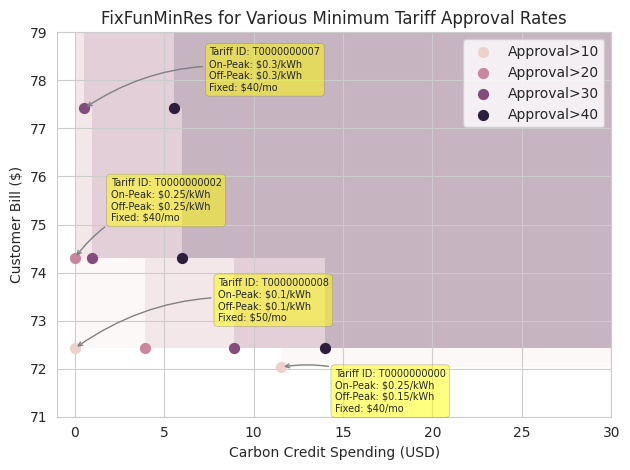

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

sns.set_style("whitegrid")

def shade_upper_sets(points, color, ax, alpha=0.15):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    for x, y in points:
        rect = Rectangle(
            (x, y),                     # lower-left corner
            xlim[1] - x,                # width
            ylim[1] - y,                # height
            facecolor=color,
            alpha=alpha,
            edgecolor=None
        )
        ax.add_patch(rect)

from matplotlib.patches import Polygon

def pareto_minimal(points):
    # Keep only points that are not dominated by another point with <=x and <=y
    pts = sorted(points, key=lambda p: (p[0], p[1]))
    frontier = []
    best_y = float('inf')
    for x, y in pts:
        if y < best_y:
            frontier.append((x, y))
            best_y = y
    return frontier

def add_upper_set_union(ax, points, color, alpha=0.15, zorder=0):
    pts = pareto_minimal(points)
    if not pts:
        return

    x_max = ax.get_xlim()[1]
    y_max = ax.get_ylim()[1]

    # Sort by x increasing; y should (weakly) decrease along the Pareto frontier
    pts = sorted(pts, key=lambda p: p[0])

    x1, y1 = pts[0]

    verts = [(x1, y_max), (x1, y1)]  # drop down at the first x

    # Build staircase: horizontal then vertical at each breakpoint
    for (x_next, y_next) in pts[1:]:
        verts.append((x_next, verts[-1][1]))  # horizontal to next x at current y
        verts.append((x_next, y_next))        # vertical down to next y

    # Extend to the right edge, then close along the top
    verts.append((x_max, verts[-1][1]))  # horizontal to x_max at last y
    verts.append((x_max, y_max))         # up to top-right

    patch = Polygon(verts, closed=True, facecolor=color, edgecolor='none',
                    alpha=alpha, zorder=zorder)
    ax.add_patch(patch)

tariffs = {
    72.0331: {
        'id': 'T0000000000', 'onpeak_price': 0.25, 'offpeak_price': 0.15,
        'fixed_charge': 40},
    72.4237: {
        'id': 'T0000000008', 'onpeak_price': 0.10, 'offpeak_price': 0.10,
        'fixed_charge': 50},
    74.3005: {
        'id': 'T0000000002', 'onpeak_price': 0.25, 'offpeak_price': 0.25,
        'fixed_charge': 40},
    77.4185: {
        'id': 'T0000000007', 'onpeak_price': 0.3, 'offpeak_price': 0.30,
        'fixed_charge': 40
    },
}

# Plot points corresponding to FixFunMinRes

approval_10 = [
    (0, 72.4237),
    (11.543653125, 72.0331)
]
approval_20 = [
    (0, 74.3005),
    (3.910582813, 72.4237)
]
approval_30 = [
    (0.530050625, 77.4185),
    (0.94210625, 74.3005),
    (8.906202813, 72.4237)
]
approval_40 = [
    (13.992251875, 72.4237),
    (5.53841375, 77.4185),
    (5.977668126, 74.3005)
]

# Plot the points for each approval rating
# Cycle colors using seaborn cubehelix_palette()
cubehelix_palette = sns.cubehelix_palette(n_colors=4)


fig, ax = plt.subplots()

ax.scatter(*zip(*approval_10), label='Approval>10', color=cubehelix_palette[0], s=50, zorder=5)
ax.scatter(*zip(*approval_20), label='Approval>20', color=cubehelix_palette[1], s=50, zorder=5)
ax.scatter(*zip(*approval_30), label='Approval>30', color=cubehelix_palette[2], s=50, zorder=5)
ax.scatter(*zip(*approval_40), label='Approval>40', color=cubehelix_palette[3], s=50, zorder=5)

ax.set_xlim(left=-1, right=30)
ax.set_ylim(bottom=71, top=79)

add_upper_set_union(ax, approval_10, cubehelix_palette[0], alpha=0.15)
add_upper_set_union(ax, approval_20, cubehelix_palette[1], alpha=0.15)
add_upper_set_union(ax, approval_30, cubehelix_palette[2], alpha=0.15)
add_upper_set_union(ax, approval_40, cubehelix_palette[3], alpha=0.15)

ax.legend(loc='upper right')
ax.set_xlabel('Carbon Credit Spending (USD)')
ax.set_ylabel('Customer Bill ($)')

# Collect all plotted points
all_points = approval_10 + approval_20 + approval_30 + approval_40

# Find closest plotted point for each tariff and annotate
for price, tariff in tariffs.items():
    # Find closest plotted point to this tariff price
    closest_point = min(all_points, key=lambda p: abs(p[1] - price))

    # Position annotations strategically to avoid overlap
    if price == 72.0331:  # Lowest price
        xytext = (closest_point[0] + 3, closest_point[1] - 0.5)
    elif price == 72.4237:  # Second lowest
        xytext = (closest_point[0] + 8, closest_point[1] + 1)
    elif price == 74.3005:  # Third
        xytext = (closest_point[0] + 2, closest_point[1] + 1.2)
    else:  # 77.4185, highest
        xytext = (closest_point[0] + 7, closest_point[1] + 0.8)

    ax.annotate(
        f"Tariff ID: {tariff['id']}\n"
        f"On-Peak: ${tariff['onpeak_price']}/kWh\n"
        f"Off-Peak: ${tariff['offpeak_price']}/kWh\n"
        f"Fixed: ${tariff['fixed_charge']}/mo",
        xy=closest_point,  # Point to the actual plotted point
        xytext=xytext,
        textcoords='data',
        arrowprops=dict(arrowstyle="->", color='gray', lw=1, connectionstyle="arc3,rad=0.2"),
        fontsize=7,
        verticalalignment='center',
        horizontalalignment='left',
        bbox=dict(boxstyle="round,pad=0.4", fc="yellow", alpha=0.5, edgecolor='gray', linewidth=0.5),
        zorder=10
    )

plt.title("FixFunMinRes for Various Minimum Tariff Approval Rates")

plt.tight_layout()
